In [1]:
# %load general_load.py
#!/usr/bin/env python3

# Imports
import csv
import math
import os, os.path
import io
import sys
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from IPython.display import display

%matplotlib inline
sb.set()

def goldilocks_temp(t):
    if t < 273:
        return -1;
    elif t > 373:
        return 1;
    else:
        return 0

csv_filename = "./Data/exoplanetarchive/candidates-20190613-TIDIED.csv"
longnames = {}
with open(csv_filename, 'r') as f:
    lines = f.readlines()
    for line in lines[8:23]:
        varname, longname = line.strip().split(':')
        varname = varname[9:].strip()
        longname = longname.replace(',', '').strip()
        #print(varname, longname)
        longnames[varname] = longname
        
dataset = pd.read_csv(csv_filename, header = 24)

goldilocks_dataset = dataset.drop(['kepid',
                                   'koi_period',
                                   'koi_period_err1',
                                   'koi_prad_err1',
                                   #'koi_insol',
                                   'koi_insol_err1', 
                                   'koi_steff',
                                   'koi_steff_err1',
                                   'koi_slogg',
                                   'koi_slogg_err1',
                                   #'koi_srad',
                                   'koi_srad_err1'],
                                  axis=1).copy()
goldilocks_dataset.head()

goldilocks_dataset["gold_temp"] = list(map(goldilocks_temp, goldilocks_dataset["koi_teq"]))
goldilocks_dataset = goldilocks_dataset.dropna()

goldX = goldilocks_dataset.drop(["kepoi_name","koi_teq","gold_temp"], axis=1)
goldY = goldilocks_dataset['gold_temp']

goldX.columns = [longnames[x] for x in goldX.columns]


In [2]:
# Following the tutorial from [https://github.com/spacetelescope/notebooks] I will attempt
# to download, plot, and view a Light Curve

# First of all, I'll need to import this:
from astropy.io import fits

## Obtaining The DVT Series File

In [3]:
# For the purposes of this tutorial, we just know the MAST URL location of the file we want to examine.
dvt_file = "https://archive.stsci.edu/missions/tess/tid/s0002/0000/0001/0010/0827/tess2018235142541-s0002-s0002-0000000100100827-00109_dvt.fits"

## Understanding The DVT File Structure

In [4]:
fits.info(dvt_file)

Filename: /home/jdowzell/.astropy/cache/download/124ac35a2c99549df3bba96cd314a11a
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      43   ()              
1    TCE_1       BinTableHDU     92   19737R x 10C   [D, E, J, E, E, E, E, E, E, E]   
2    TCE_2       BinTableHDU     92   19737R x 10C   [D, E, J, E, E, E, E, E, E, E]   
3    Statistics  BinTableHDU    157   19737R x 38C   [D, E, J, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


In [5]:
fits.getdata(dvt_file, ext=1).columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'PHASE'; format = 'E'; unit = 'days'; disp = 'E14.7'
    name = 'LC_INIT'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'LC_INIT_ERR'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'LC_WHITE'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'LC_DETREND'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'MODEL_INIT'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'MODEL_WHITE'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
)

## Plotting The Timeseries Fluxes

In [6]:
with fits.open(dvt_file, mode="readonly") as hdulist:
    
    # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
    # and TESS magnitude.
    star_teff = hdulist[0].header['TEFF']
    star_logg = hdulist[0].header['LOGG']
    star_tmag = hdulist[0].header['TESSMAG']
    
    # Extract some of the fit parameters for the first TCE.  These are stored in the FITS header of the first
    # extension.
    period = hdulist[1].header['TPERIOD']
    duration = hdulist[1].header['TDUR']
    epoch = hdulist[1].header['TEPOCH']
    depth = hdulist[1].header['TDEPTH']
    
    # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
    # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
    # model fluxes.
    times = hdulist[1].data['TIME']
    phases = hdulist[1].data['PHASE']
    fluxes_init = hdulist[1].data['LC_INIT']
    model_fluxes_init = hdulist[1].data['MODEL_INIT']

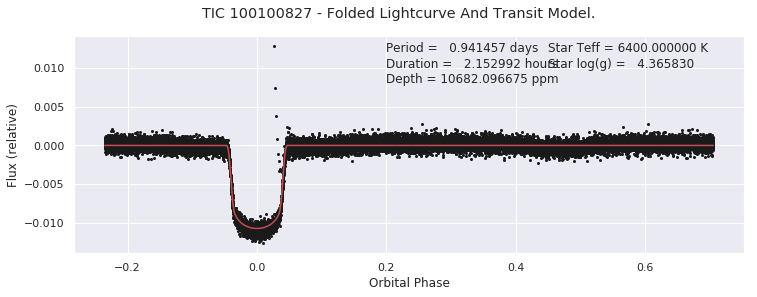

In [7]:
# First sort the phase and flux arrays by phase so we can draw the connecting lines between points.
sort_indexes = np.argsort(phases)

# Start figure and axis.
fig, ax = plt.subplots(figsize=(12,4))

# Plot the detrended fluxes as black circles.  We will plot them in sorted order.
ax.plot(phases[sort_indexes], fluxes_init[sort_indexes], 'ko',
       markersize=2)

# Plot the model fluxes as a red line.  We will plot them in sorted order so the line connects between points cleanly.
ax.plot(phases[sort_indexes], model_fluxes_init[sort_indexes], '-r')

# Let's label the axes and define a title for the figure.
fig.suptitle('TIC 100100827 - Folded Lightcurve And Transit Model.')
ax.set_ylabel("Flux (relative)")
ax.set_xlabel("Orbital Phase")

# Let's add some text in the top-right containing some of the fit parameters.
plt.text(0.2, 0.012, "Period = {0:10.6f} days".format(period))
plt.text(0.2, 0.010, "Duration = {0:10.6f} hours".format(duration))
plt.text(0.2, 0.008, "Depth = {0:10.6f} ppm".format(depth))
plt.text(0.45, 0.012, "Star Teff = {0:10.6f} K".format(star_teff))
plt.text(0.45, 0.010, "Star log(g) = {0:10.6f}".format(star_logg))

plt.show()

## Examining The Statistics Extension

In [8]:
fits.getdata(dvt_file, ext=3).columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'sigma'; disp = 'E14.7'
    name = 'RESIDUAL_LC'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'DEWEIGHTS'; format = 'E'; unit = 'proportion'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'SES_CORR_0_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_1_0'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_1_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_2_0'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_2_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_3_0'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_3_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_4_5'; format = 'E'; disp = 'E14.7'
